In [40]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np


In [41]:
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution()
    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

X =  tensor([10.1178, 16.1580, 13.5076, 11.2088, 12.5260, 10.2046, 12.3598,  5.3744,
         6.6123,  4.1637, 10.6486, 19.8746,  9.8743, 13.7181,  6.4959,  6.3838,
         8.8710, 13.7528,  7.8492,  4.2128, 32.1217, 31.6692, 27.9260, 25.2772,
        30.1989, 28.7326, 27.5394, 31.2168, 29.8592, 32.5586, 35.0382, 28.7210,
        25.3125, 26.9449, 29.7215, 32.2714, 26.2530, 22.4461, 31.5835, 31.4890])


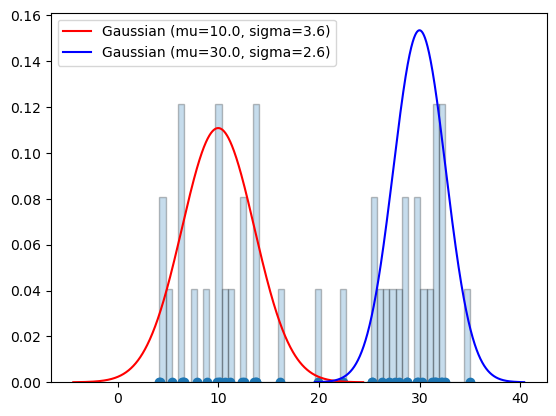

In [42]:
n = 20
mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

# 1)
# Generates data that follows two gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

# a) Scatter Plot with histograms
# Histograms
plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
# Scatter
plt.scatter(X,torch.zeros(len(X)))
# Density
x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})', color='red')
plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})', color='blue')
plt.legend()
plt.show()



In [43]:
# 2)
def init_random_parameters(k=2, range=50):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[39.4258, 13.2479],
        [35.3144, 44.3661]])


In [44]:
# 3)
def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)
print('likelihood_test = ', likelihood_test)


likelihood_test =  tensor(-2.2004)


In [45]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

M =  tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


/tmp/ipykernel_6111/2467604469.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [49]:
#5)

def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    mu_1 = torch.mean(k1_tentative_values)
    mu_2 = torch.mean(k2_tentative_values)
    sigma_1 = torch.std(k1_tentative_values)
    sigma_2 = torch.std(k2_tentative_values)
    return torch.tensor([[mu_1, sigma_1],[mu_2, sigma_2]])

print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Old P parameters:  None
New P parameters:  tensor([[28.8931,  3.6457],
        [ 9.6863,  3.5107]])
